# ML2 Assignment - Probability of Attrition

**Import libraries**

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, zscore

from sklearn import preprocessing, linear_model 
from sklearn.model_selection import cross_val_score, ShuffleSplit, validation_curve, cross_validate, train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve
from sklearn.pipeline import make_pipeline
import dataset
import numpy as np

from statsmodels.discrete.discrete_model import Logit

import sklearn.tree as tree

import featuretools as ft

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')

## Data Import

**Put apart 10% of the dataset as an (unseen) holdout portion**

In [2]:
df_whole = pd.read_csv("https://gist.githubusercontent.com/f-loguercio/42ce10f1ec834a1030f6193e44df1ade/raw/970f4326a412a504fc270cca4de6978ce027250d/turnover.csv")

df_train, df_test = train_test_split(df_whole, test_size=0.1, random_state=123)

df_raw = df_train

df_holdout = df_test

print(df_whole.count())
df_raw.head()

satisfaction_level       14999
last_evaluation          14999
number_project           14999
average_montly_hours     14999
time_spend_company       14999
Work_accident            14999
left                     14999
promotion_last_5years    14999
sales                    14999
salary                   14999
dtype: int64


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
13003,0.61,0.42,3,104,2,0,0,0,hr,medium
100,0.38,0.52,2,154,3,0,1,0,sales,medium
4372,0.52,0.71,2,231,2,0,0,0,sales,low
14629,0.42,0.53,3,199,4,0,1,0,technical,medium
372,0.39,0.48,2,141,3,0,1,0,product_mng,medium


In [3]:
df_raw.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.612886,0.715255,3.798430,201.113194,3.503667,0.143714,0.238907,0.021261
std,0.248548,0.171450,1.232269,49.832369,1.465375,0.350813,0.426431,0.144258
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [4]:
df_holdout.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.612360,0.723720,3.844667,200.484667,3.449333,0.152667,0.230667,0.021333
std,0.249454,0.168488,1.235134,50.942188,1.411652,0.359786,0.421400,0.144541
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.570000,3.000000,155.000000,3.000000,0.000000,0.000000,0.000000
50%,0.650000,0.730000,4.000000,198.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,246.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Overall, the holdout set appears fairly representative, without major differences from the non-holdout set.

## Data Preparation and Exploratory Data Analysis

### Transform variable types to most suitable type

In [5]:
df_raw.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Levels of sales and salary (categorical variables):

In [6]:
#df_raw.sales.unique()  #commented as they take long to run

In [7]:
#df_raw.salary.unique()

### Change variable type to category for categorical variables

In [8]:
df_raw['sales'] = df_raw['sales'].astype('category')
df_raw['salary'] = df_raw['salary'].astype('category')

In [9]:
df = df_raw.copy()
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.612886,0.715255,3.798430,201.113194,3.503667,0.143714,0.238907,0.021261
std,0.248548,0.171450,1.232269,49.832369,1.465375,0.350813,0.426431,0.144258
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Check for missing values

In [10]:
for i in list(df):
    print(i, sum(df[i].isnull()))

satisfaction_level 0
last_evaluation 0
number_project 0
average_montly_hours 0
time_spend_company 0
Work_accident 0
left 0
promotion_last_5years 0
sales 0
salary 0


In [11]:
for i in list(df_holdout):
    print(i, sum(df_holdout[i].isnull()))

satisfaction_level 0
last_evaluation 0
number_project 0
average_montly_hours 0
time_spend_company 0
Work_accident 0
left 0
promotion_last_5years 0
sales 0
salary 0


### Explore Skewness


**Logistic regression does not assume normality in explanatory variables, but we will still explore skewness**

Define auxilliary functions

In [12]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df) 
    return(list(set(df.columns) - set(numerical_columns)))

In [13]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64',
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric_features.append(i)
    feature_skew = df[numeric_features].apply(
        lambda x: x.skew()).sort_values(ascending=False)
    
    skews = pd.DataFrame({'skew': feature_skew}) 
    return feature_skew, numeric_features

In [14]:
feature_skewness(df)

(promotion_last_5years    6.638250
 Work_accident            2.031502
 time_spend_company       1.856561
 left                     1.224732
 number_project           0.340628
 average_montly_hours     0.052356
 last_evaluation         -0.019931
 satisfaction_level      -0.475902
 dtype: float64,
 ['satisfaction_level',
  'last_evaluation',
  'number_project',
  'average_montly_hours',
  'time_spend_company',
  'Work_accident',
  'left',
  'promotion_last_5years'])

In [15]:
feature_skewness(df_holdout)

(promotion_last_5years    6.632100
 Work_accident            1.933356
 time_spend_company       1.814508
 left                     1.279985
 number_project           0.312071
 average_montly_hours     0.058395
 last_evaluation         -0.085482
 satisfaction_level      -0.480883
 dtype: float64,
 ['satisfaction_level',
  'last_evaluation',
  'number_project',
  'average_montly_hours',
  'time_spend_company',
  'Work_accident',
  'left',
  'promotion_last_5years'])

None of the non-dichotomous variables are excessively (>0.5) skewed.

### Scale variables

Logistic regression itself does not need scaled variables, but we will still scale them in case we want to perform regularization, which does need scaled variables to work optimally.

This step was originally here. As it appears that scaling can also hurt a model, it was chosen to scale the variables later when regularisation is attempted.

### OneHot Encoding

In [16]:
def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df,
                            pd.get_dummies(df[categorical_column],
                                           prefix=categorical_column)],
                           axis=1)
    return new_df

In [17]:
df_enc = onehot_encode(df)
df_holdout = onehot_encode(df_holdout)
df_enc.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
count,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,...,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.612886,0.715255,3.798430,201.113194,3.503667,0.143714,0.238907,0.021261,0.081710,0.487592,...,0.081043,0.052596,0.050448,0.048152,0.043188,0.057708,0.059930,0.277502,0.148752,0.180680
std,0.248548,0.171450,1.232269,49.832369,1.465375,0.350813,0.426431,0.144258,0.273932,0.499865,...,0.272911,0.223235,0.218876,0.214095,0.203288,0.233199,0.237367,0.447783,0.355857,0.384767
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Basic statistics of each (numerical) variable

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,13499.0,0.612886,0.248548,0.09,0.44,0.64,0.82,1.0
last_evaluation,13499.0,0.715255,0.171450,0.36,0.56,0.72,0.87,1.0
number_project,13499.0,3.798430,1.232269,2.00,3.00,4.00,5.00,7.0
average_montly_hours,13499.0,201.113194,49.832369,96.00,156.00,200.00,245.00,310.0
time_spend_company,13499.0,3.503667,1.465375,2.00,3.00,3.00,4.00,10.0
Work_accident,13499.0,0.143714,0.350813,0.00,0.00,0.00,0.00,1.0
left,13499.0,0.238907,0.426431,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,13499.0,0.021261,0.144258,0.00,0.00,0.00,0.00,1.0


Create comparison table of means for export

In [19]:
overall_stats = pd.DataFrame()
overall_stats['mean_all'] = df.describe().loc['mean']

df_not_left = df[df['left']==0]
df_left = df[df['left']==1]

overall_stats['mean_left'] = df_left.describe().loc['mean']
print(overall_stats)

                         mean_all   mean_left
satisfaction_level       0.612886    0.438881
last_evaluation          0.715255    0.717318
number_project           3.798430    3.855504
average_montly_hours   201.113194  207.256744
time_spend_company       3.503667    3.873178
Work_accident            0.143714    0.044341
left                     0.238907    1.000000
promotion_last_5years    0.021261    0.005581


**Explore correlations in raw data**

This can help determine whether it will be best to unfold categorical variables or their ordering makes sense.

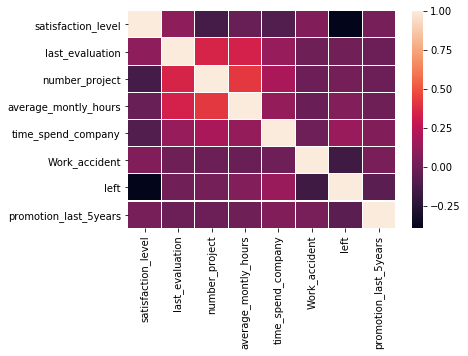

In [20]:
sns.heatmap(df.corr(),linewidths=.1)
plt.show()

Satisfaction level stands out for being strongly correlated with left

**Distribution across different departments and levels of income**

The following graphs show proportions relative to the subclass (left or did not leave)!

Text(0.5, 1.0, 'Departments')

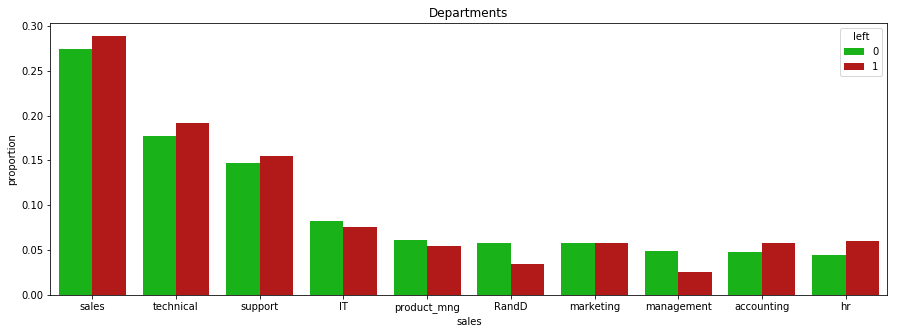

In [21]:
mycol = ["#00cb00", "#cb0000"]
sns.set_palette(mycol)

df_hue = df.copy()
my_y, hue = "proportion", "left"

plt.subplots(figsize=(15,5))

prop_df_salary = (df_hue['sales']
           .groupby(df_hue[hue])
           .value_counts(normalize=True)
           .rename(my_y)
           .reset_index())

sns.barplot(x='sales', y=my_y, hue=hue, data=prop_df_salary).set_title('Departments')

Text(0.5, 1.0, 'Salary')

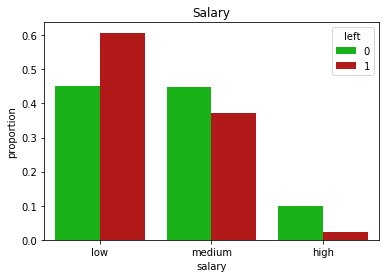

In [22]:
mycol = ["#00cb00", "#cb0000"]
sns.set_palette(mycol)

df_hue = df.copy()
my_y, hue = "proportion", "left"
hue_order = ['low', 'medium', 'high']

prop_df_salary = (df_hue['salary']
           .groupby(df_hue[hue])
           .value_counts(normalize=True)
           .rename(my_y)
           .reset_index())

sns.barplot(x='salary', y=my_y, hue=hue, data=prop_df_salary).set_title('Salary')

### Histograms of each variable

Last Evaluation

Text(0.5, 1.0, 'Last Evaluation')

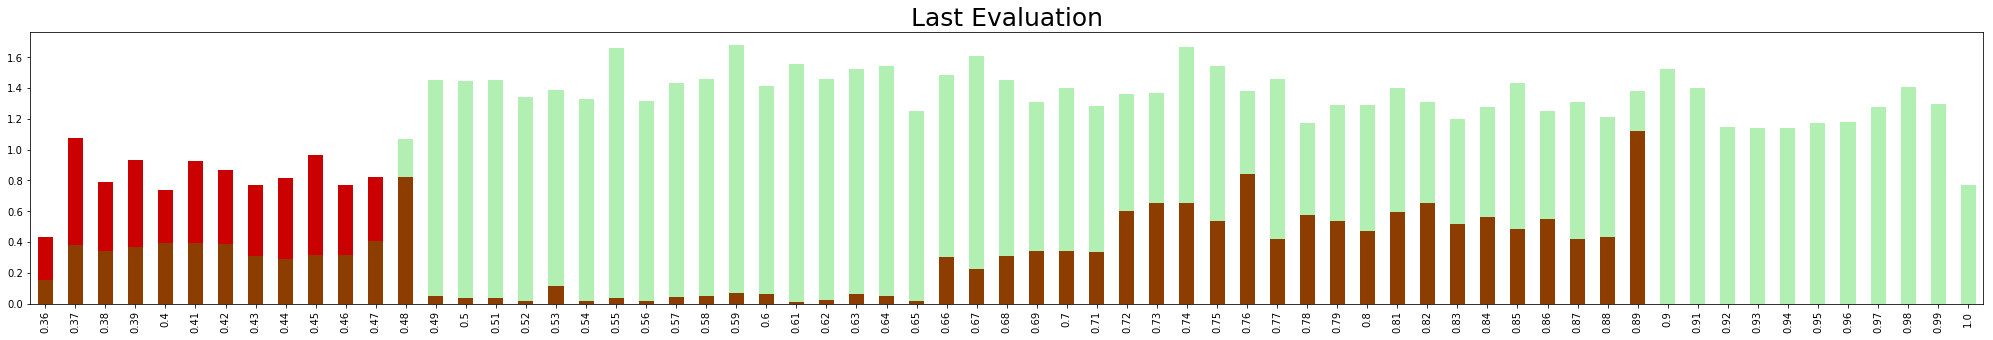

In [23]:
plt.figure(figsize=(35,5))
((df[df.left==1].last_evaluation.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = '#cb0000')
((df[df.left==0].last_evaluation.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = '#00cb00',alpha=0.3)
plt.title('Last Evaluation', fontsize = 25)

Avg Monthly Hours

Text(0.5, 1.0, 'Average Monthly Hours')

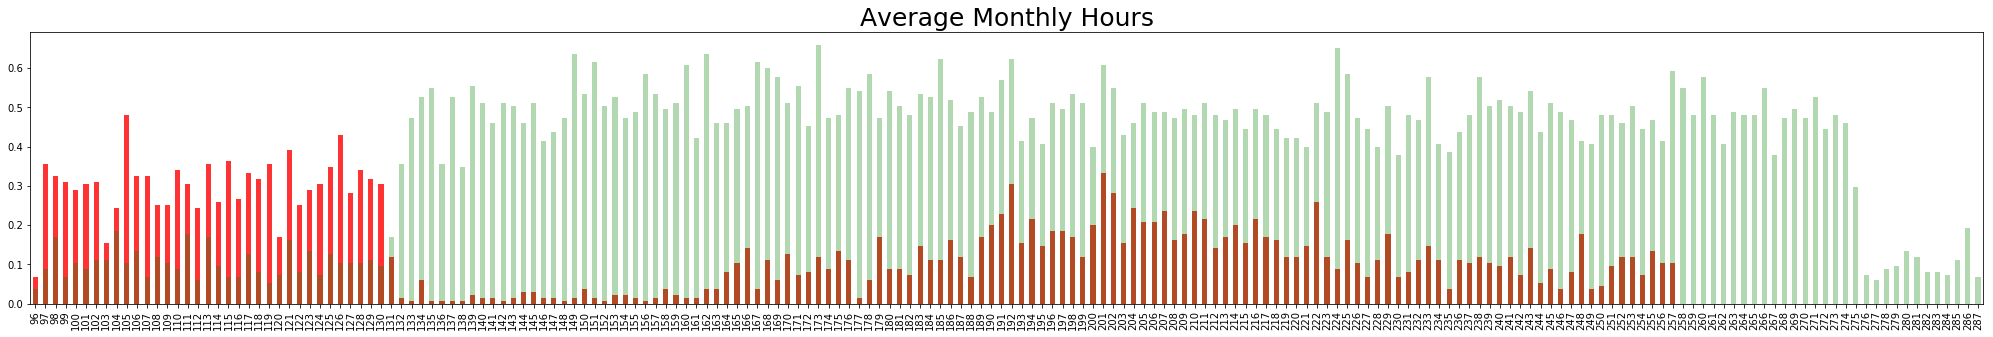

In [24]:
plt.figure(figsize=(35,5))
((df[df.left==1].average_montly_hours.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = 'r', alpha = 0.8)
((df[df.left==0].average_montly_hours.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = 'g',alpha=0.3)
plt.title('Average Monthly Hours', fontsize = 25)

Projects per Year

Text(0.5, 1.0, 'Number of Projects')

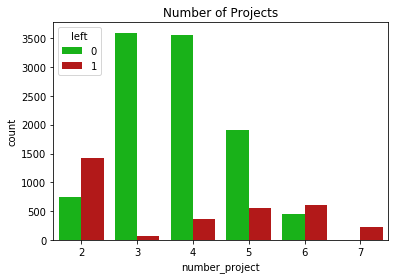

In [25]:
sns.countplot(x = 'number_project', hue = 'left', data = df).set_title('Number of Projects')

Satisfaction Level

Text(0.5, 1.0, 'Satisfaction Level')

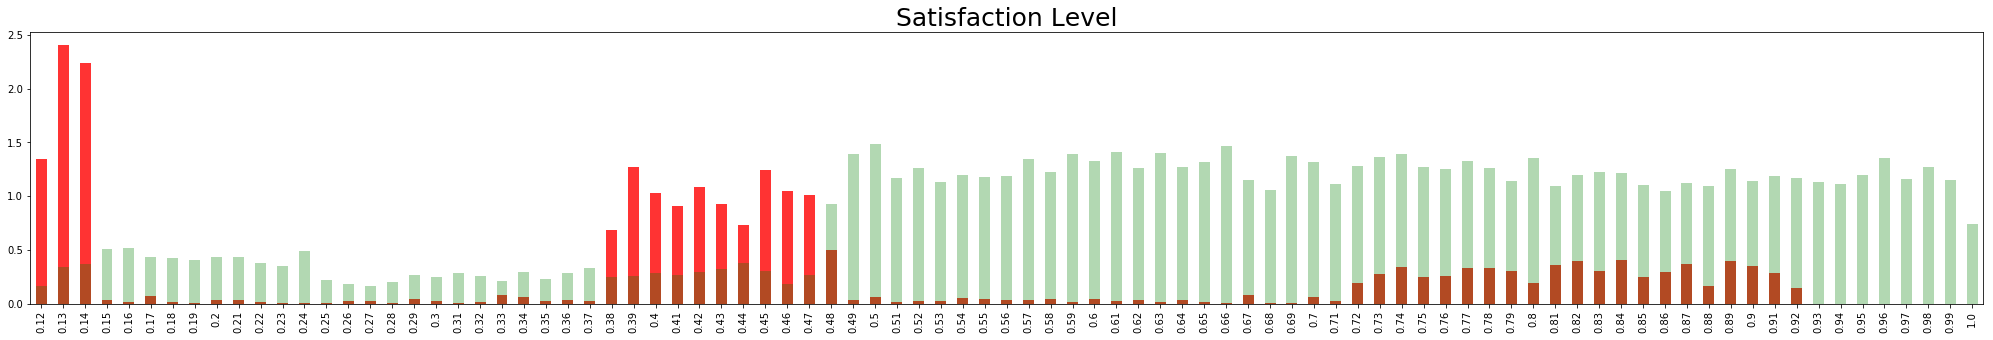

In [26]:
plt.figure(figsize=(35,5))
((df[df.left==1].satisfaction_level.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = 'r', alpha = 0.8)
((df[df.left==0].satisfaction_level.value_counts().sort_index()/len(df.left))*100).plot(kind='bar', color = 'g',alpha=0.3)
plt.title('Satisfaction Level', fontsize = 25)

Time spent at Company

Text(0.5, 1.0, 'Years spent at company')

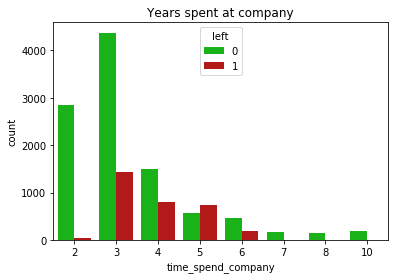

In [27]:
sns.countplot(x = 'time_spend_company', hue = 'left', data = df).set_title('Years spent at company')

### Analyse two-way patterns

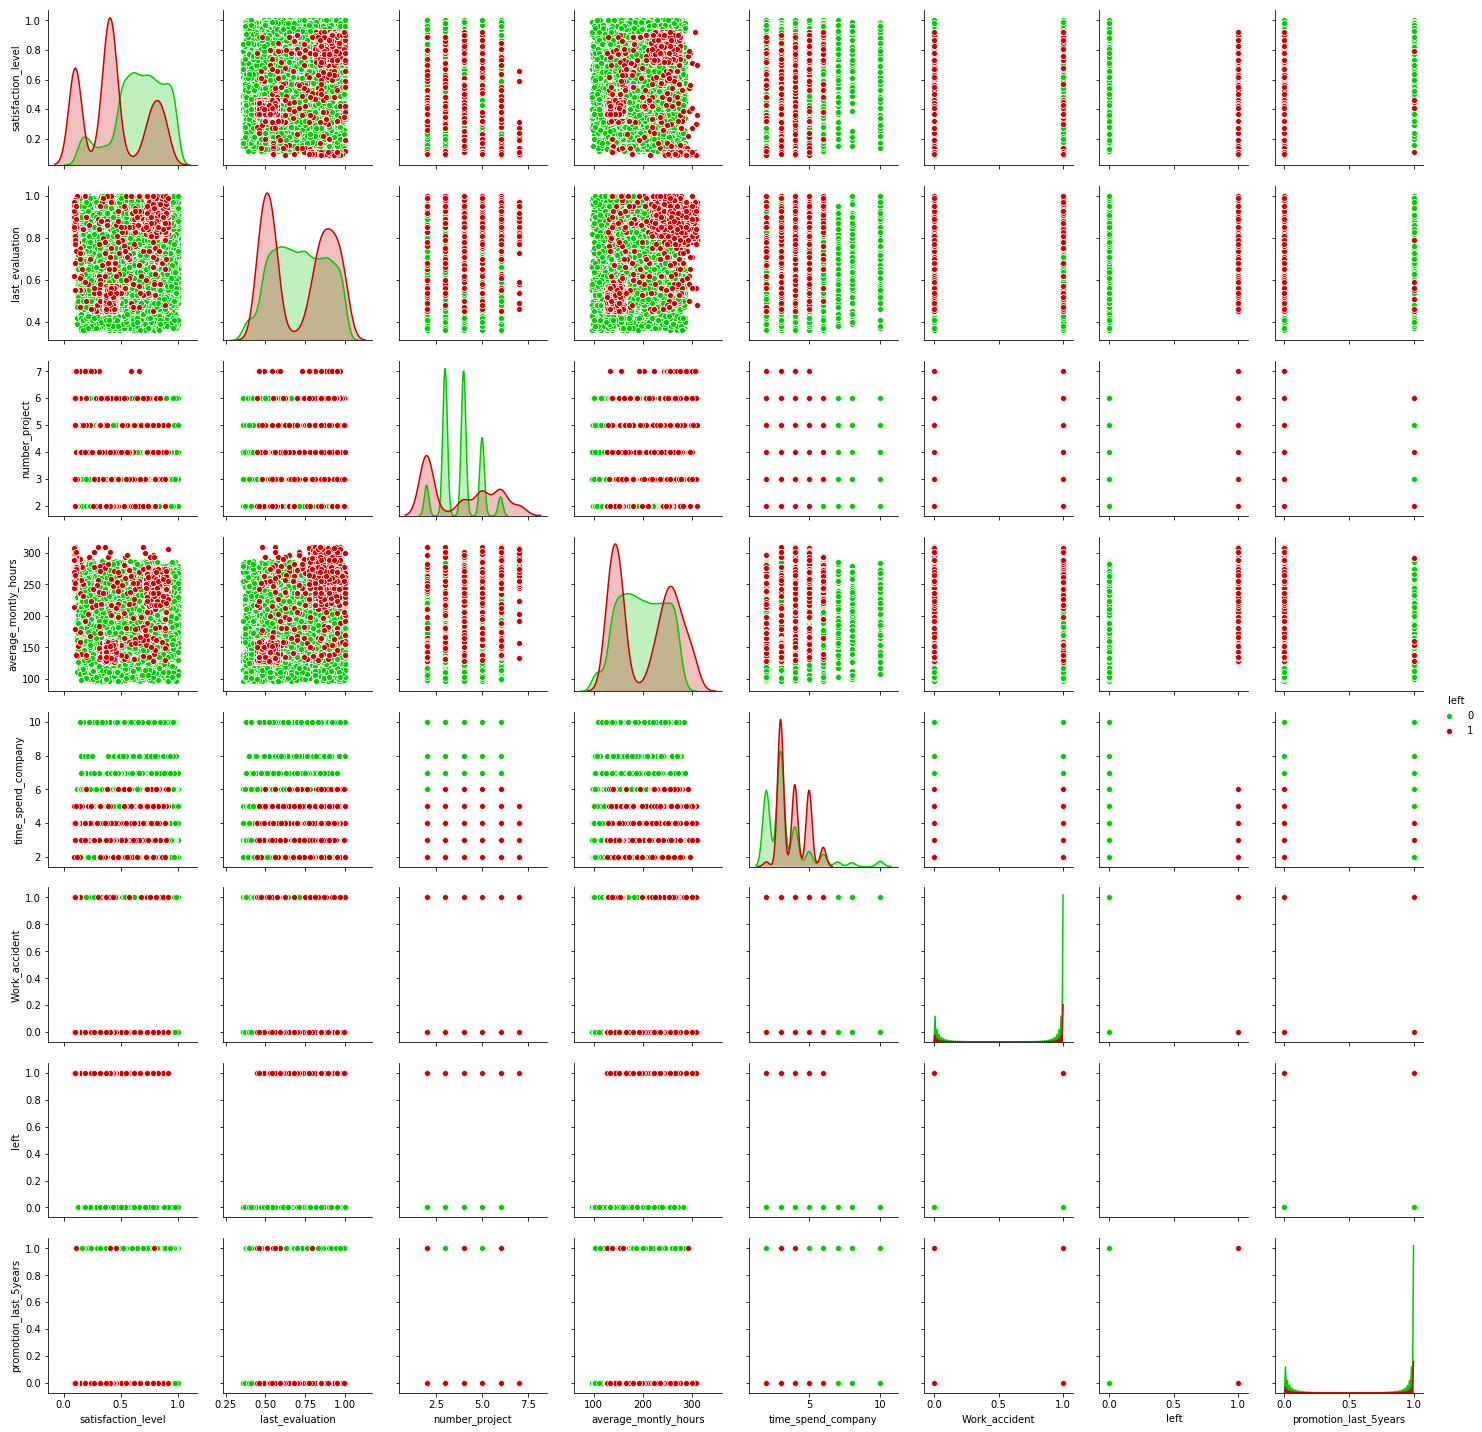

In [28]:
sns.pairplot(df,hue = "left")

Explore some of these further:

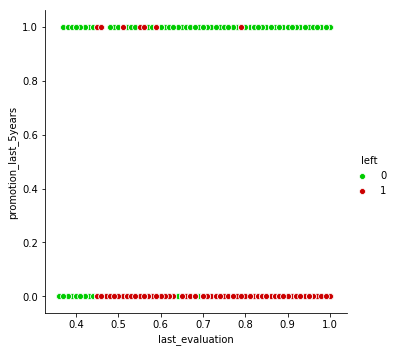

In [29]:
sns.pairplot(df, x_vars = 'last_evaluation', y_vars = 'promotion_last_5years', hue = "left", height = 5)

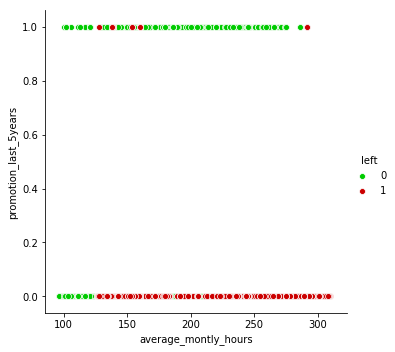

In [30]:
sns.pairplot(df, x_vars = 'average_montly_hours', y_vars = 'promotion_last_5years', hue = "left", height = 5)

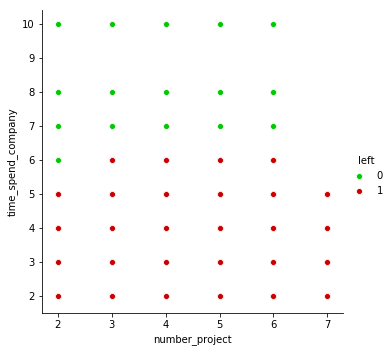

In [31]:
sns.pairplot(df, x_vars = 'number_project', y_vars = 'time_spend_company', hue = "left", height = 5)

## Baseline

In [32]:
X_train = df_enc.loc[:, df_enc.columns != 'left']
y_train = df_enc['left']

In [33]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary_high,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
13003,0.61,0.42,3,104,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
100,0.38,0.52,2,154,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4372,0.52,0.71,2,231,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
14629,0.42,0.53,3,199,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
372,0.39,0.48,2,141,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


CV accuracy (left out fold, but train set)

In [34]:
model = linear_model.LogisticRegression()
scores = cross_val_score(model,  
                         X_train, y_train,
                         cv=5,
                         scoring='accuracy')
print('Obtained {} Accuracy scores'.format(len(scores)))
print('Best Validation Accuracy: {:.2f}'.format(max(scores)))
print('Avg. Validation Accuracy: {:.2f}'.format(np.mean(scores)))

Obtained 5 Accuracy scores
Best Validation Accuracy: 0.80
Avg. Validation Accuracy: 0.79


Score model on the hold out test set:

In [35]:
X_holdout_baseline = df_holdout.loc[:, df_holdout.columns != 'left']
y_holdout_baseline = df_holdout['left']

# Obtain scores and estimators from different splits and use the best one.
scores = cross_validate(model, 
                        X_train, y_train,
                        scoring=['accuracy'], 
                        cv=5,
                        return_estimator=True)
split_scores = [scores['estimator'][i].score(X_holdout_baseline, y_holdout_baseline) 
                for i in range(len(scores))]
index_best = split_scores.index(max(split_scores))
print('Best estimator Accuracy score: {:.2f}'.format(split_scores[index_best]))

Best estimator Accuracy score: 0.80


Have a look at the coefficients and significance (without CV!)

In [36]:
logit = Logit(y_train, X_train)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.427931
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                13499
Model:                          Logit   Df Residuals:                    13480
Method:                           MLE   Df Model:                           18
Date:                Sun, 17 Feb 2019   Pseudo R-squ.:                  0.2217
Time:                        23:31:40   Log-Likelihood:                -5776.6
converged:                       True   LL-Null:                       -7422.0
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -4.1631      0.104    -40.214      0.000      -4.366      -3.960
last_evaluation           0.7634      0.157      4.850      0.000       0.455       1.072
number_project           -0.3097      0.023    -13.720      0.000      -0.354      -0.265
average_montly_hours      0.0042      0.001      7.734      0.000       0.003       0.005
time_spend_company        0.2632      0.016     16.081      0.000       0.231       0.295
Work_accident            -1.5905      0.097    -16.449      0.000      -1.780      -1.401
promotion_last_5years    -1.3434      0.265     -5.071      0.000      -1.863      -0.824
salary_high              -1.4643        nan        nan        nan         nan         nan
salary_low                0.4954        nan        nan        nan         nan         nan
salary_medium            -0.0400        nan        nan        nan         nan         nan
sales_IT                 -0.1924        nan        nan        nan         nan         nan
sales_RandD              -0.5630        nan        nan        nan         nan         nan
sales_accounting          0.0378        nan        nan        nan         nan         nan
sales_hr                  0.2367        nan        nan        nan         nan         nan
sales_management         -0.4600        nan        nan        nan         nan         nan
sales_marketing          -0.0215        nan        nan        nan         nan         nan
sales_product_mng        -0.1686        nan        nan        nan         nan         nan
sales_sales              -0.0023        nan        nan        nan         nan         nan
sales_support             0.0478        nan        nan        nan         nan         nan
sales_technical           0.0767        nan        nan        nan         nan         nan
=========================================================================================
"""

## Feature Engineering

### Create Pipeline

In [37]:
def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > 0:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions, engineered_data

**Define function for baseline score**

In [38]:
def score_model(data, seed=666):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create logistic regression object
    regr = linear_model.LogisticRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    return accuracy_score(y_test, y_pred)

**Cross Evaluation**

In [39]:
def cv_evaluate(df):
    logit = linear_model.LogisticRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=23)

    X = df.drop(['left'], axis=1)
    y = df.left.reset_index(drop=True)
    benchmark_model = make_pipeline(logit).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='accuracy', cv=kfolds)
    return scores[scores >= 0.0]

## Feature Engineering

**Features created through common sense**

In [40]:
def hours_per_project(df):
    df['hours_per_project'] = df['average_montly_hours'] / df['number_project']
    return df

In [41]:
def long_hours_many_projects(df):
    df['long_hours_many_projects'] = df['average_montly_hours'] * df['number_project'] / 100
    return df

In [42]:
def no_salary_base_cat(df):
    df.drop('salary_low', axis=1)
    return df

In [43]:
def no_sales_base_cat(df):
    df.drop('sales_sales', axis=1)
    return df

**Features derived from EDA**

In [44]:
def binned_hours(df):
    df['binned_working_hours'] = pd.cut(df['average_montly_hours'], 10).astype('category')
    df.drop('average_montly_hours', axis=1)
    df = onehot_encode(df)
    return df

In [45]:
def binned_evaluation(df):
    df['binned_evaluation'] = pd.cut(df['last_evaluation'], 10).astype('category')
    df = onehot_encode(df)
    return df

In [46]:
def year_as_category(df):
    df['year_as_category'] = df['time_spend_company'].astype('category')
    df = onehot_encode(df)
    return df

In [47]:
def projects_as_category(df):
    df['projects_as_category'] = df['number_project'].astype('category')
    df = onehot_encode(df)
    return df

In [48]:
def binned_satisfaction(df):
    df['binned_satisfaction'] = pd.cut(df['satisfaction_level'], 10).astype('category')
    df = onehot_encode(df)
    return df

In [49]:
def workhardnopromotion(df):
    df['workhardnopromotion'] = np.where((df['promotion_last_5years'] == 0) & (df['average_montly_hours'] > 125), 1, 0)
    return df

**Features derived from decision tree**

**Fit decision tree to find optimal splitting points for FE**

In [50]:
my_d_tree = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 1)
my_d_tree = my_d_tree.fit(X_train, y_train)

In [51]:
print(my_d_tree.feature_importances_) 

[5.18031598e-01 1.46841481e-01 1.05307009e-01 7.71227455e-02
 1.45209328e-01 3.72046588e-04 2.27713058e-04 5.28161168e-04
 3.74358311e-04 6.51967354e-04 9.74385233e-04 3.95131729e-04
 8.45142866e-05 2.88660461e-04 0.00000000e+00 8.73825230e-05
 0.00000000e+00 2.32586703e-05 1.89065912e-03 1.58960021e-03]


In [52]:
print(my_d_tree.score(X_holdout_baseline, y_holdout_baseline))

0.9793333333333333


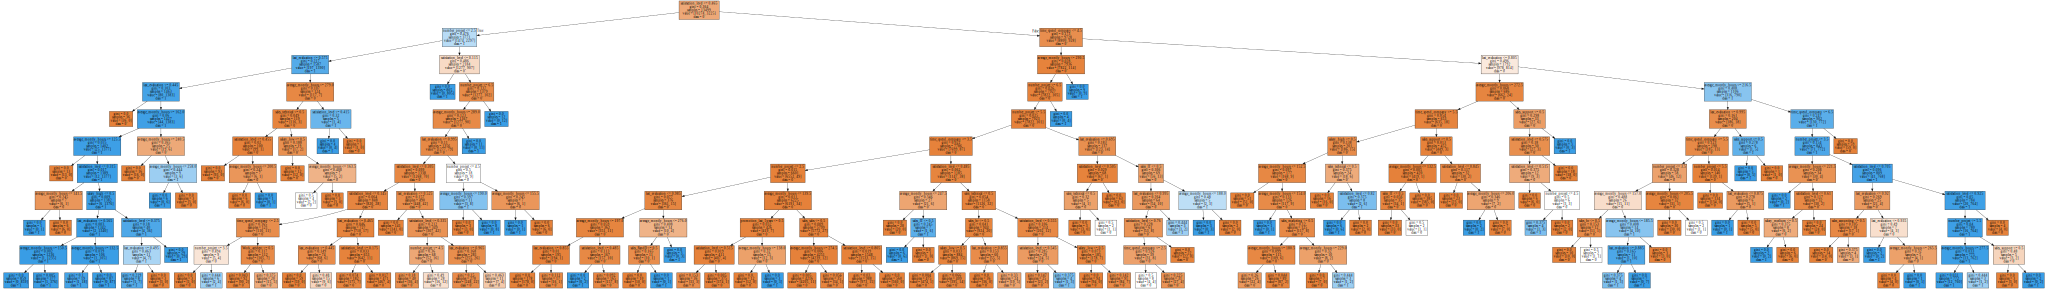

In [53]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

labels = list(X_train.columns.values)

graph = Source(tree.export_graphviz(my_d_tree, out_file=None
   , feature_names=labels, class_names=['0', '1', '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [54]:
def high_satisfaction_little_time(df):
    df['high_satisfaction_little_time'] = np.where((df['satisfaction_level']  > 0.465) & ((df['time_spend_company']  <= 4.5)), 1, 0)
    return df

In [55]:
def low_satisfaction_few_projects(df):
    df['low_satisfaction_few_projects'] = np.where((df['satisfaction_level']  <= 0.465) & ((df['number_project']  <= 2.5)), 1, 0)
    return df

In [56]:
def scale_df(df):
    df['time_spend_company'] = preprocessing.scale(df['time_spend_company'])
    df['number_project'] = preprocessing.scale(df['number_project'])
    df['average_montly_hours'] = preprocessing.scale(df['average_montly_hours'])
    df['last_evaluation'] = preprocessing.scale(df['last_evaluation'])
    df['satisfaction_level'] = preprocessing.scale(df['satisfaction_level'])
    return df

In [57]:
def remove_outliers(df):
    df = df[(np.abs(zscore(df[['satisfaction_level', 'last_evaluation', 'average_montly_hours']])) < 3).all(axis=1)]
    return df

In [58]:
fe_functions = ['hours_per_project', 'long_hours_many_projects', 'no_salary_base_cat', 'no_sales_base_cat',
                
                'high_satisfaction_little_time', 'low_satisfaction_few_projects', 
                
                 'workhardnopromotion', 'binned_hours',
                'binned_evaluation', 'year_as_category', 
                'projects_as_category', 'remove_outliers']
#Due to a pipeline malfunction, if 'scale_df' is included in the functions, 
#it changes the data permanently even though it is rejected

funcs, new_dataset = feature_engineering_pipeline(df_enc, fe_functions)

# After running the FE pipeline, I check how CV make my results shuffle, 
# as it takes different portions of the data each time, and that causes 
# different metric values
acc = cv_evaluate(new_dataset)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(acc), np.std(acc)))

Base Score: 0.7970
- New Score (hours_per_project): 0.7985 [diff: 0.0015] [Accepted]
- New Score (long_hours_many_projects): 0.8926 [diff: 0.0941] [Accepted]
- New Score (no_salary_base_cat): 0.8926 [diff: 0.0000] [Rejected]
- New Score (no_sales_base_cat): 0.8926 [diff: 0.0000] [Rejected]
- New Score (high_satisfaction_little_time): 0.9452 [diff: 0.0526] [Accepted]
- New Score (low_satisfaction_few_projects): 0.9522 [diff: 0.0070] [Accepted]
- New Score (workhardnopromotion): 0.9548 [diff: 0.0026] [Accepted]
- New Score (binned_hours): 0.9563 [diff: 0.0015] [Accepted]
- New Score (binned_evaluation): 0.9581 [diff: 0.0019] [Accepted]
- New Score (year_as_category): 0.9615 [diff: 0.0033] [Accepted]
- New Score (projects_as_category): 0.9619 [diff: 0.0004] [Accepted]
- New Score (remove_outliers): 0.9619 [diff: 0.0000] [Rejected]
Mean Accuracy after CV: 0.961 +/- 0.002


In [59]:
new_dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,year_as_category_6,year_as_category_7,year_as_category_8,year_as_category_10,projects_as_category_2,projects_as_category_3,projects_as_category_4,projects_as_category_5,projects_as_category_6,projects_as_category_7
count,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,...,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.612886,0.715255,3.798430,201.113194,3.503667,0.143714,0.238907,0.021261,0.081710,0.487592,...,0.048448,0.012816,0.010964,0.014520,0.160160,0.271057,0.290910,0.182754,0.078302,0.016816
std,0.248548,0.171450,1.232269,49.832369,1.465375,0.350813,0.426431,0.144258,0.273932,0.499865,...,0.214719,0.112483,0.104136,0.119624,0.366768,0.444522,0.454199,0.386479,0.268656,0.128587
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Holdout FE Pipeline**

Add all features that were selected above to the holdout dataset

First, modify pipeline to accept all features

This function uniquely serves the purpose to prepare the holdout dataset and the corresponding model. (It would not need to do most of the steps it does, it was just minimally adapted.)

In [60]:
def feature_engineering_holdout_pipeline(raw_data, fe_functions_holdout):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions_holdout:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        selected_functions.append(fe_function)
        engineered_data = processed_data.copy()
        base_score = new_score
        print('[Accepted]')
    return selected_functions, engineered_data

In [61]:
fe_functions_holdout = ['hours_per_project', 'long_hours_many_projects',
                        
                'high_satisfaction_little_time', 'low_satisfaction_few_projects',
                
                'workhardnopromotion', 'binned_hours', 'binned_evaluation', 'year_as_category', 
                'projects_as_category']
funcs_holdout, new_dataset_holdout = feature_engineering_holdout_pipeline(df_holdout, fe_functions_holdout)

Base Score: 0.7667
- New Score (hours_per_project): 0.7800 [diff: 0.0133] [Accepted]
- New Score (long_hours_many_projects): 0.8533 [diff: 0.0733] [Accepted]
- New Score (high_satisfaction_little_time): 0.9600 [diff: 0.1067] [Accepted]
- New Score (low_satisfaction_few_projects): 0.9667 [diff: 0.0067] [Accepted]
- New Score (workhardnopromotion): 0.9667 [diff: 0.0000] [Accepted]
- New Score (binned_hours): 0.9767 [diff: 0.0100] [Accepted]
- New Score (binned_evaluation): 0.9733 [diff: -0.0033] [Accepted]
- New Score (year_as_category): 0.9733 [diff: 0.0000] [Accepted]
- New Score (projects_as_category): 0.9767 [diff: 0.0033] [Accepted]


**Accuracy score on holdout set by taking the best-generalising model**

REFCV

In [62]:
from sklearn.feature_selection import RFECV

X_train = new_dataset.loc[:, new_dataset.columns != 'left']
y_train = new_dataset['left']

X_holdout = new_dataset_holdout.loc[:, new_dataset_holdout.columns != 'left']
y_holdout = new_dataset_holdout['left']

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
pipeline = make_pipeline(
    RFECV(estimator = linear_model.LogisticRegression(n_jobs=-1),cv = cv, scoring = 'accuracy')).fit(X_train, y_train)
scores = cross_val_score(pipeline, X_train, y_train,
                         scoring="accuracy", cv=cv)

print('Best CV accuracy: {:.2f}'.format(max(scores)))
print('Avg. CV accuracy: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('Accuracy in hold-out dataset: {:.3f}'.format(
    pipeline.score(X_holdout, y_holdout)))

Best CV accuracy: 0.96
Avg. CV accuracy: 0.96 +/- 0.0041
Accuracy in hold-out dataset: 0.955


Explore, whether any features were excluded:

In [63]:
selector = RFECV(estimator = linear_model.LogisticRegression(n_jobs=-1),cv = cv, scoring = 'accuracy').fit(X_train, y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

One base category of each categorical variable suggested to be dropped

Polynomial features

In [68]:
X_train = new_dataset.loc[:, new_dataset.columns != 'left']
y_train = new_dataset['left']

X_holdout = new_dataset_holdout.loc[:, new_dataset_holdout.columns != 'left']
y_holdout = new_dataset_holdout['left']

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    linear_model.LogisticRegression(n_jobs=-1)).fit(X_train, y_train)
scores = cross_val_score(pipeline, X_train, y_train,
                         scoring="accuracy", cv=cv)

print('Best CV accuracy: {:.2f}'.format(max(scores)))
print('Avg. CV accuracy: {:.2f} +/- {:.02}'.format(
    np.mean(scores[scores > 0.0]),
    np.std(scores[scores > 0.0])))
print('Accuracy in hold-out dataset: {:.3f}'.format(
    pipeline.score(X_holdout, y_holdout)))

Best CV accuracy: 0.97
Avg. CV accuracy: 0.96 +/- 0.0043
Accuracy in hold-out dataset: 0.957


**Optimise penalty parameter for regularisation**

In [59]:
# Setting up the penalties to be considered
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Instantiate a logistic regression classifier: logreg
logreg = linear_model.LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

X = new_dataset.loc[:, new_dataset.columns != 'left']
y = new_dataset['left']
# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 21.544346900318832, 'penalty': 'l2'}
Best score is 0.9611823098007259


In [67]:
# Obtain scores and estimators from different splits and use the best one.
X = new_dataset.loc[:, new_dataset.columns != 'left']
y = new_dataset['left']

X_holdout = new_dataset_holdout.loc[:, new_dataset_holdout.columns != 'left']
y_holdout = new_dataset_holdout['left']

model_tuned = linear_model.LogisticRegression(C = 21.544346900318832, penalty = 'l2')

scores = cross_validate(model_tuned, 
                        X, y,
                        scoring=['accuracy'], 
                        cv=5,
                        return_estimator=True)

split_scores = [scores['estimator'][i].score(X_holdout, y_holdout) 
                for i in range(len(scores))]
index_best = split_scores.index(max(split_scores))
print('Best estimator Accuracy score: {:.3f}'.format(split_scores[index_best]))

Best estimator Accuracy score: 0.958
